In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/NORMAL.metadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/Viral Pneumonia.matadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/COVID-19.metadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/README.md.txt
/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/NORMAL/NORMAL (159).png
/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/NORMAL/NORMAL (1106).png
/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/NORMAL/NORMAL (825).png
/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/NORMAL/NORMAL (1245).png
/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/NORMAL/NORMAL (391).png
/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/NORMAL/NORMAL (28).png
/kaggle/input/covid19-radiography-dat

/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (625).png
/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (661).png
/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (1024).png
/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (815).png
/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (1117).png
/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (1137).png
/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (1296).png
/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (1171).png
/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/Vi

In [11]:
%matplotlib inline
import os
import shutil
import random
import torch
import torchvision
import numpy as np
from distutils.dir_util import copy_tree
from tqdm import tqdm
import cv2, os, gc, glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Pytorch version', torch.__version__)

print('All files imported')

Pytorch version 1.6.0
All files imported


In [10]:
os.mkdir("/kaggle/temp")
os.mkdir("/kaggle/temp/COVID-19 Radiography Database")

from_dir = "../input/covid19-radiography-database/COVID-19 Radiography Database/"
to_dir = "/kaggle/temp/COVID-19 Radiography Database/"
shutil.rmtree(to_dir)
shutil.copytree(from_dir, to_dir)

FileExistsError: [Errno 17] File exists: '/kaggle/temp'

In [ ]:
#Visualising the dataset

In [12]:
# Image paths

imagePaths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))
            

# Data - Label

Data = []
Target = []
resize = 150

cat = {'Viral Pneumonia': 'Pneumonia', 'NORMAL': 'Normal', 'COVID-19': 'Covid-19'}

for imagePath in tqdm(imagePaths):
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (resize, resize)) /255

    Data.append(image)
    Target.append(cat[label])
    
    


100%|██████████| 2905/2905 [01:03<00:00, 46.08it/s]


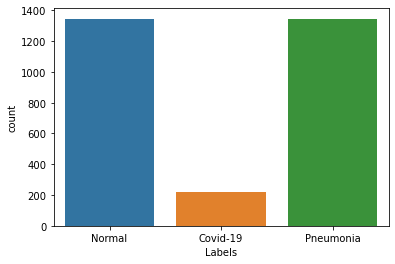

Covid-19: 219
Normal: 1341
Pneumonia:  1345


In [13]:
# Count by Label

df = pd.DataFrame(Target,columns=['Labels'])
sns.countplot(df['Labels'])
plt.show()

print('Covid-19:',Target.count('Covid-19'))
print('Normal:',Target.count('Normal'))
print('Pneumonia: ',Target.count('Pneumonia'))

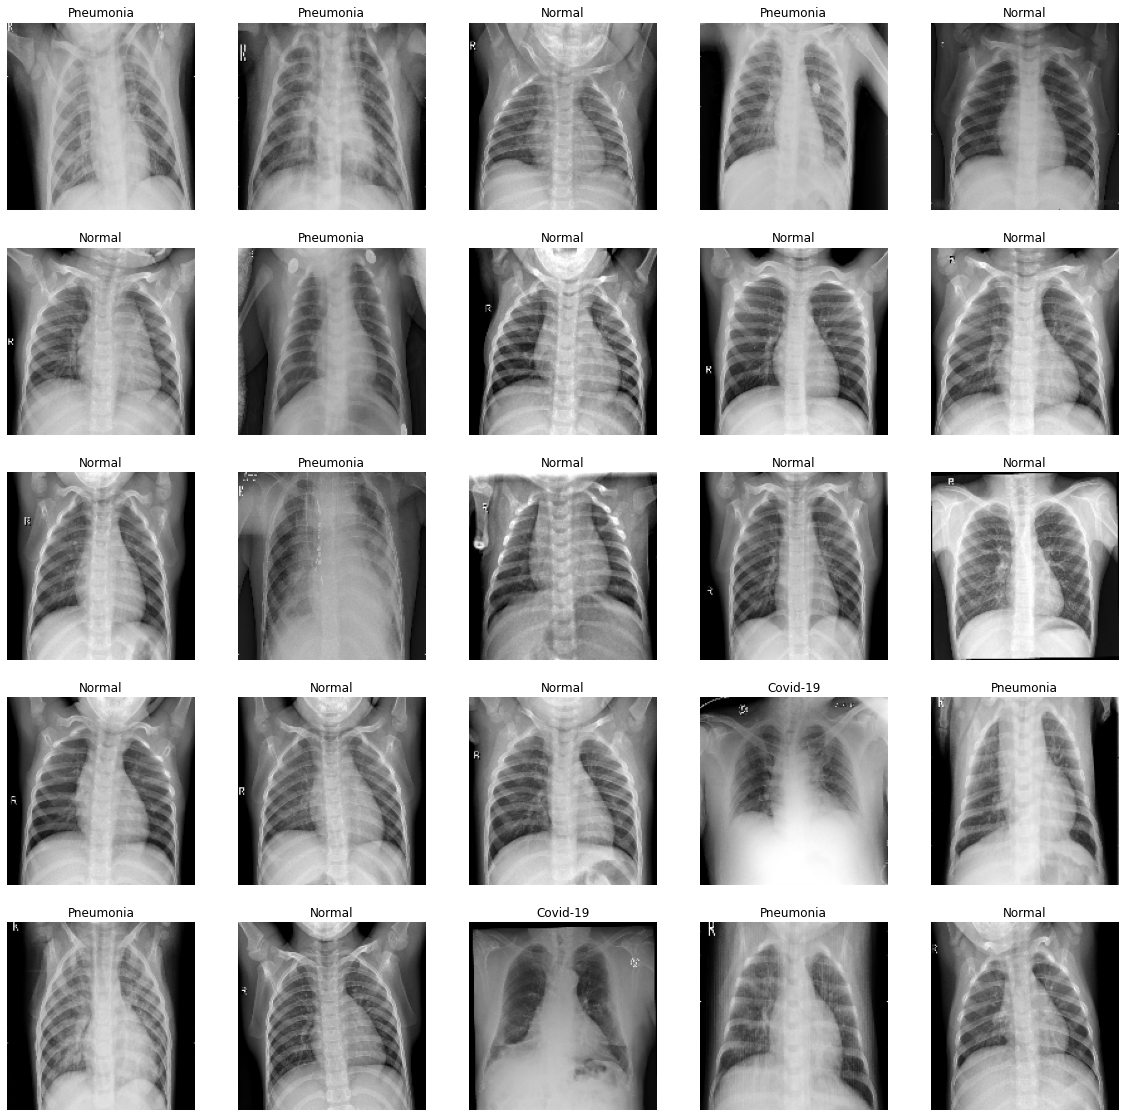

In [14]:
# Show Images

plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(imagePaths),25))) : 
    plt.subplot(5,5,n+1)
    plt.imshow(Data[i] , cmap='gray')
    plt.title(Target[i])
    plt.axis('off')     
plt.show()

In [15]:
class_names =['normal', 'viral', 'covid']
root_dir = '/kaggle/temp/COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))
    
    for i,d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))
        
    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))
        
    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

In [16]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f"Found {len(images)} {class_name} examples")
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [17]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224,224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225])
])

In [18]:
train_dirs = {
    'normal' : '/kaggle/temp/COVID-19 Radiography Database/normal',
    'viral' : '/kaggle/temp/COVID-19 Radiography Database/viral',
    'covid' : '/kaggle/temp/COVID-19 Radiography Database/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 189 covid examples


In [19]:
test_dirs = {
    'normal' : '/kaggle/temp/COVID-19 Radiography Database/test/normal',
    'viral' : '/kaggle/temp/COVID-19 Radiography Database/test/viral',
    'covid' : '/kaggle/temp/COVID-19 Radiography Database/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [20]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size,
                                      shuffle = True)

dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size,
                                      shuffle = True)

print('Num of training batches', len(dl_train))
print("Num of test batches", len(dl_test))

Num of training batches 470
Num of test batches 15


In [21]:
class_name = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize = (8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks = [], yticks = [])
        image = image.numpy().transpose((1,2,0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        plt.imshow(image)
        
        col = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = col)
    plt.tight_layout()
    plt.show()

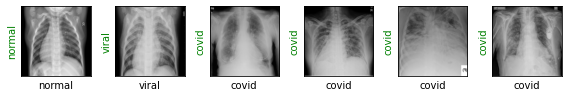

In [22]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

In [25]:
resnet18 = torchvision.models.resnet18(pretrained = True)
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


URLError: <urlopen error [Errno -3] Temporary failure in name resolution>

In [24]:
resnet18.fc = torch.nn.Linear(in_features = 512, out_features = 3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

NameError: name 'resnet18' is not defined

In [ ]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

In [ ]:
show_preds()

In [ ]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print("="*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print("="*20)
        
        train_loss = 0
        resnet18.train()
        
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print("Evaluating at step", train_step)
                acc = 0
                val_loss = 0
                resnet18.eval()
                
                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    _,preds = torch.max(outputs, 1)
                    acc += sum((preds == labels).numpy())
                val_loss /= (val_step + 1)
                acc /= len(test_dataset)
                print(f'Val loss: {val_loss:.4f}, Acc: {acc:.4f}')
                show_preds()
                
                resnet18.train()
                if acc >= 0.95:
                    print('Performance condition satisfied')
                    return
        train_loss /= (train_step + 1)
        print(f'Training loss: {train_loss:.4f}') 

In [ ]:
train(epochs=1)

In [ ]:
show_preds()